# PREDICCIÓN DE PAGOS EN CLIENTES DE TARJETA DE CRÉDITO

Mauricio Valencia Escobar (mvalence@unal.edu.co) - Universidad Nacional de Colombia sede Medellín

El conjunto de datos para el desarrollo este trabajo fue tomado del sitio web del centro de aprendizaje de máquinas y sistemas inteligentes UCI y contiene información de los pagos de las cuotas de tarjetas de crédito de un banco de Taiwám desde Abril a Septiembre de 2005.

Página web: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

Data set: default of credit card clients

Metodología del trabajo:

El problema se abordará con la metodología CRISP-DM.

1.	Definición del problema
2.	Descripción de los datos
3.	Preparación de los datos
4.	Modelado y evaluación
5.	Conclusiones


# 1.	DEFINICIÓN DEL PROBLEMA

1.1  Definición del problema real

Un banco de Taiwán requiere administrar el riesgo de su producto de tarjetas de crédito, para lo cual decide predecir si sus clientes pagarán o no oportunamente su proxima cuota, para lo cual se basarán en la información historica entre abril y septiembre de 2005, la cual cuenta con los datos personales del cliente, saldos de los créditos y su respectiva oportunidad en los pagos. 

1.2 Definición del problema en términos de los datos

Se tiene una muestra de 30.000 registros y 25 variables. Entre las variables se tiene información personal del cliente, del crédito y el cumplimento de los pagos incluyendo una etiqueta binaria que indica si cumplirá o no el próximo pago. Se requiere utilizar al menos  cuatro técnicas de clasificación para evaluar cual logra predecir mejor dichos cumplimiento deacuerdo a la naturaleza del problema.

Variables del dataset:



En términos de los datos, se desea pronosticar si un cliente pagará o no oportunamente la proxima cuota a partir de las 25 variables.

# Importaciones de Librerías

In [1235]:
## Eliminamos salida de warnings
import warnings as ws
ws.filterwarnings("ignore")

## Generales
import numpy as np
from itertools import chain
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")
import re # regex
import time as tm
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

## Librerías de las Metodologías
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

## Librerías de apoyo a las Metodologías
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Carga de datos

In [1236]:
dfc = pd.read_csv('default of credit card clients.csv', sep=";", skiprows=1) #skipprows salta fila que no agrega valor.

dfc.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Limpieza de la información

En el conjunto de datos, se evidencia que:

- Se omite una columna PAY_1. Suponemos que PAY_0 es en realidad PAY_1.
- La variable objetivo tiene un nombre muy largo se cambia el nombre default payment next month por Pred_pay.
- La columna ID no agrega valor al análisis, por lo que procedemos a eliminarla.
- Las variables están en mayuscula, por facilidad se convierten a minusculas.


In [1237]:
dfc = dfc.rename(columns={'PAY_0': 'PAY_1', 'default payment next month': 'Pred_pay'})
dfc = dfc.drop('ID', axis=1)
dfc.columns = [x.lower() for x in dfc.columns]

dfc.head()

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,pred_pay
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# 2. DESCRIPCIÓN DE LOS DATOS

In [1238]:
#Inspección general:
dfc.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
limit_bal    30000 non-null int64
sex          30000 non-null int64
education    30000 non-null int64
marriage     30000 non-null int64
age          30000 non-null int64
pay_1        30000 non-null int64
pay_2        30000 non-null int64
pay_3        30000 non-null int64
pay_4        30000 non-null int64
pay_5        30000 non-null int64
pay_6        30000 non-null int64
bill_amt1    30000 non-null int64
bill_amt2    30000 non-null int64
bill_amt3    30000 non-null int64
bill_amt4    30000 non-null int64
bill_amt5    30000 non-null int64
bill_amt6    30000 non-null int64
pay_amt1     30000 non-null int64
pay_amt2     30000 non-null int64
pay_amt3     30000 non-null int64
pay_amt4     30000 non-null int64
pay_amt5     30000 non-null int64
pay_amt6     30000 non-null int64
pred_pay     30000 non-null int64
dtypes: int64(24)
memory usage: 5.5 MB


Se analizan la información general de los datos y se concluye que:

- El conjunto de datos contiene 30000 Ejemplos cada uno con 24 variables.
- Aunque hay variables con naturaleza categorica, se encuentran numerizadas.
- El data Set no contiene datos nulos.
- Todas las variables son numeros enteros.

In [1239]:
dfc.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
limit_bal,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
sex,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
education,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
marriage,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
age,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
pay_1,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
pay_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
pay_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
pay_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0
pay_5,30000.0,-0.266200,1.133187,-2.0,-1.00,0.0,0.00,8.0


Para facilitar el entendimiento de la exploración descriptiva, pondremos etiquetas a las variables categoricas:

In [1240]:
#converción a categoricas:
dfc['sex'] = dfc['sex'].astype('category').cat.rename_categories(['Hombre', 'Mujer'])
dfc['marriage'] = dfc['marriage'].astype('category').cat.rename_categories(['na', 'married', 'single', 'other'])
dfc['age_cat'] = pd.cut(dfc['age'], range(0, 100, 10), right=False)
#dfc['pred_pay'] = dfc['pred_pay'].astype('category').cat.rename_categories(['Cumple', 'Incumple'])

Variables exploratorias:  24
Variable Objetivo:       pred_pay
Porcentaje de cumplimiento: 77.9% 


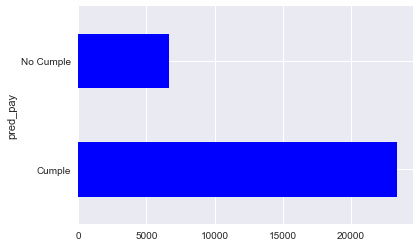

In [1241]:
#Definición de variables de entrada y salida de los modelos
print("Variables exploratorias:  {}".format(len(dfc.columns)-1))
print("Variable Objetivo:       pred_pay")


#Predicción ingeninua
Cump = 100*round(1 - (dfc.pred_pay.sum() / len(dfc.pred_pay)),3)

dfc['pred_pay'] = dfc['pred_pay'].astype('category').cat.rename_categories(['Cumple', 'No Cumple'])

m = dfc.groupby(['pred_pay']).size()
p = m.plot(kind='barh', color='blue')

print("Porcentaje de cumplimiento: {}% ".format(Cump))

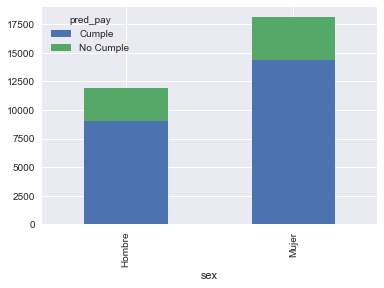

In [1242]:
ed = dfc.groupby(['sex', 'pred_pay']).size().unstack()
ed.plot(kind = 'bar', stacked = True)

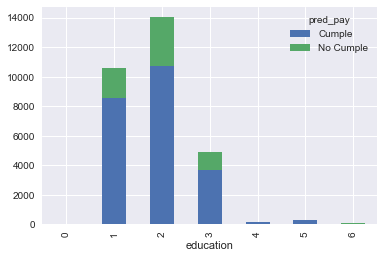

In [1243]:
ed = dfc.groupby(['education', 'pred_pay']).size().unstack()
ed.plot(kind = 'bar', stacked = True)

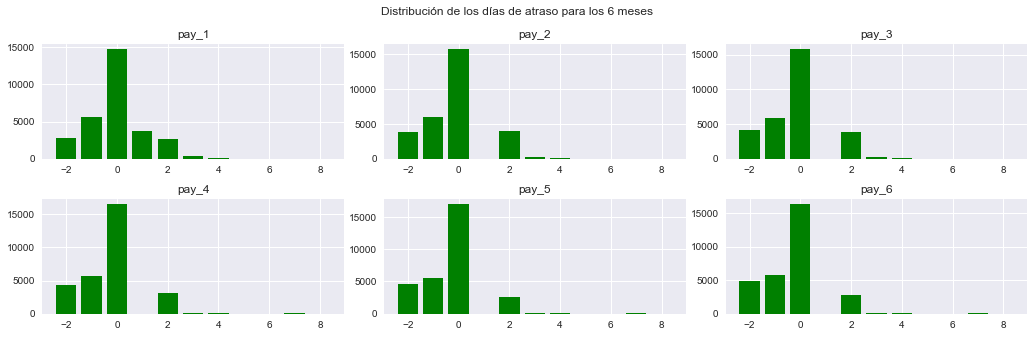

In [1244]:
# Revisando graficamente el estado de cuenta en los meses previos:
reco = re.compile("^pay_[0-9]+$")
estado_pagos = [ x for x in dfc.columns if (reco.match(x))]

fig, ax = plt.subplots(2,3)
fig.set_size_inches(15,5)
fig.suptitle('Distribución de los días de atraso para los 6 meses')

for i in range(len(estado_pagos)):
    row,col = int(i/3), i%3

    d  = dfc[estado_pagos[i]].value_counts()
    ax[row,col].bar(d.index, d, align='center', color='g')
    ax[row,col].set_title(estado_pagos[i])

plt.tight_layout(pad=3.0, w_pad=0.5, h_pad=1.0)
plt.show()

Se evidencia en los gráficos que: 
- Hay clientes con 1 ó 2 cuotas adelantadas.
- La mayoría pagan en el mes establecido de la cuota. 
- Hay clientes con atrasos de 2 meses principalmente.

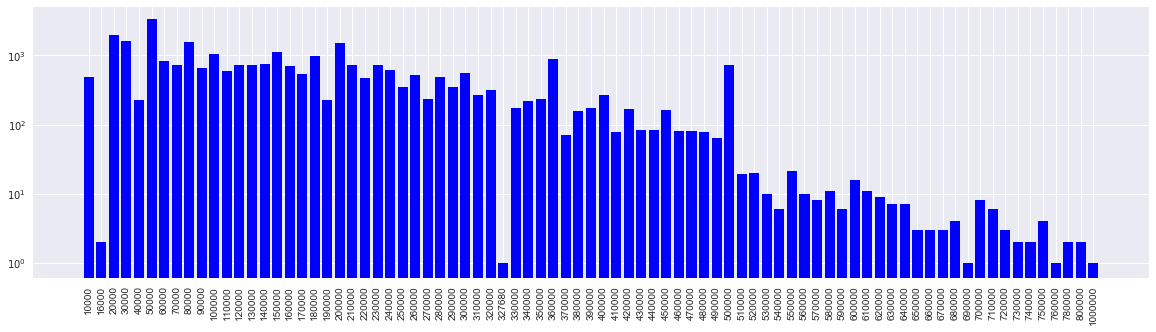

In [1245]:
# Cantidad de dinero prestada
fig = plt.figure()
fig.set_size_inches(20,5)
ax = fig.add_subplot(111)

d = dfc.groupby(['limit_bal']).size()
ax.set_yscale("log")
ax.set_xticks(np.arange(len(d)))
ax.set_xticklabels(['%d' % i for i in d.index], rotation='vertical')
p = ax.bar(np.arange(len(d)), d, color='blue')

Con el fin de analizar graficamente la influencia entre las variables categoricas sobre la variable objetivo, revisemos los siguientes histogramas:

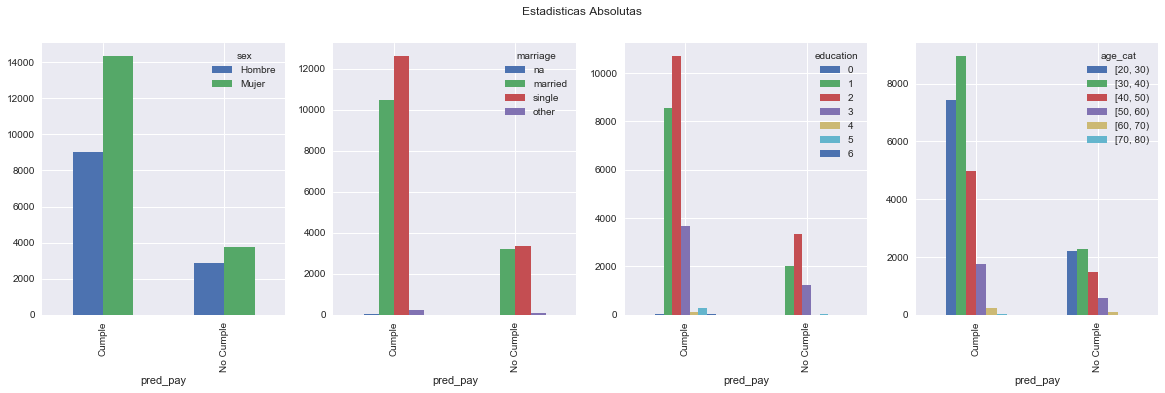

In [1246]:

fig, ax = plt.subplots(1,4)
fig.set_size_inches(20,5)
fig.suptitle('Estadisticas Absolutas')                   
                    
m = dfc.groupby(['pred_pay', 'sex']).size()
n = m.unstack(level=1).plot(kind='bar', ax=ax[0])
m = dfc.groupby(['pred_pay', 'marriage']).size()
n = m.unstack(level=1).plot(kind='bar', ax=ax[1])
m = dfc.groupby(['pred_pay', 'education']).size()
n = m.unstack(level=1).plot(kind='bar', ax=ax[2])
m = dfc.groupby(['pred_pay', 'age_cat']).size()
n = m.unstack(level=1).plot(kind='bar', ax=ax[3])



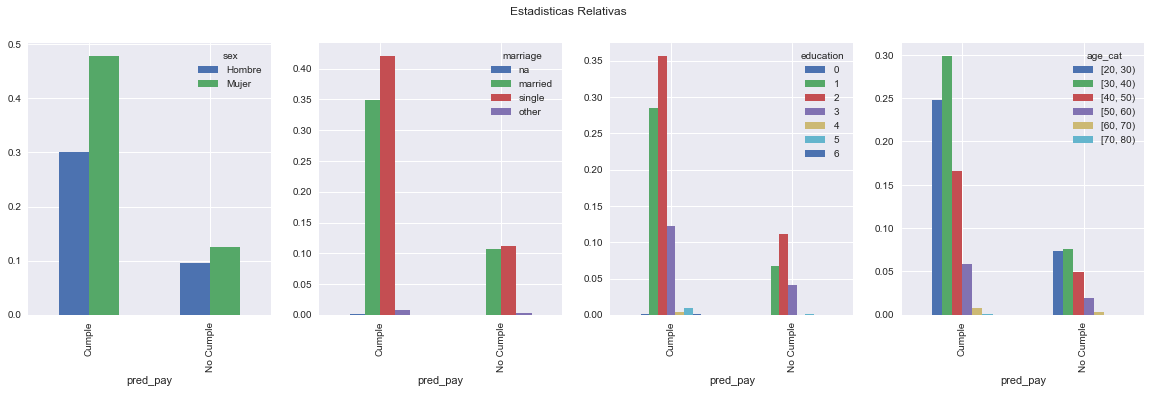

In [1247]:
fig, ax = plt.subplots(1,4)
fig.set_size_inches(20,5)
fig.suptitle('Estadisticas Relativas')                  
                    
m = dfc.groupby(['pred_pay', 'sex']).size()
m = m / m.sum()
n = m.unstack(level=1).plot(kind='bar', ax=ax[0])
m = dfc.groupby(['pred_pay', 'marriage']).size()
m = m / m.sum()
n = m.unstack(level=1).plot(kind='bar', ax=ax[1])
m = dfc.groupby(['pred_pay', 'education']).size()
m = m / m.sum()
n = m.unstack(level=1).plot(kind='bar', ax=ax[2])
m = dfc.groupby(['pred_pay', 'age_cat']).size()
m = m / m.sum()
n = m.unstack(level=1).plot(kind='bar', ax=ax[3])

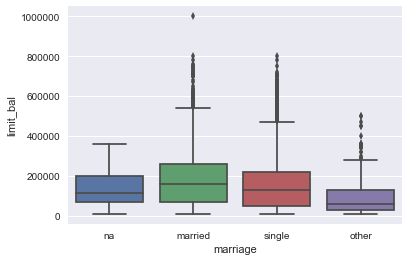

In [1248]:
sns.boxplot(x="marriage", y="limit_bal", data=dfc)

In [1249]:
#numeración de categoricas:
dfc['sex'] = dfc['sex'].astype('category').cat.rename_categories(['1', '2'])
dfc['marriage'] = dfc['marriage'].astype('category').cat.rename_categories(['1', '2', '3', '4'])
dfc = dfc.drop('age_cat', 1)
dfc['pred_pay'] = dfc['pred_pay'].astype('category').cat.rename_categories(['0', '1'])

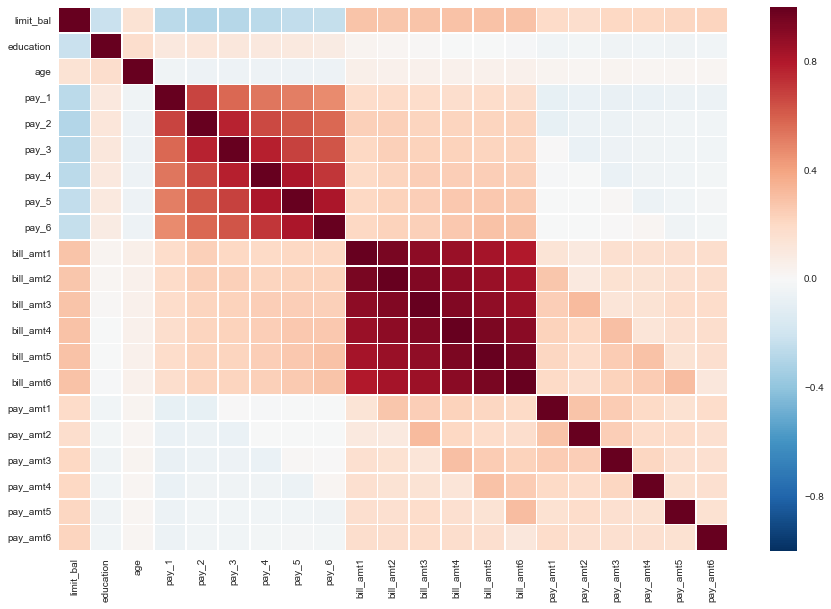

In [1250]:
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(dfc.corr(method = 'pearson'), fmt="d", linewidths=.5, ax=ax)

En la matriz de correlaciones se puede notar que las variables con mayor correlación son:

- Días de retraso en cada mes con los demás días de retaso.
- Saldo de cada mes con el saldos de los meses cercanos.

Para ambos tipos de variables, es notable que la correlación disminuye entre más separados estén los meses.   

# Preparación de datos para el modelado

Inicialmente, separamos los datos en dos conjuntos: variable objetivo y conjunto de datos.
Luego se exploran los datos para identificar si es necesario realizar una estandarización.

In [1251]:
dfc.head()

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,pred_pay
0,20000,2,2,2,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,3,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,3,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,2,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,2,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [1252]:
X_columns = [name for name in dfc.columns if name != "pred_pay"]   # Nombres de variables exploratorias
y = dfc.loc[:,"pred_pay"]   # Variable objetivo
X = dfc.loc[:,X_columns]  # Variables exploratorias
X_names = X.columns    # Nombres de variables exploratorias

## Realizamos una copia de los conjuntos originales
y = y.astype('int')

X_org = X.copy()
y_org = y.copy()

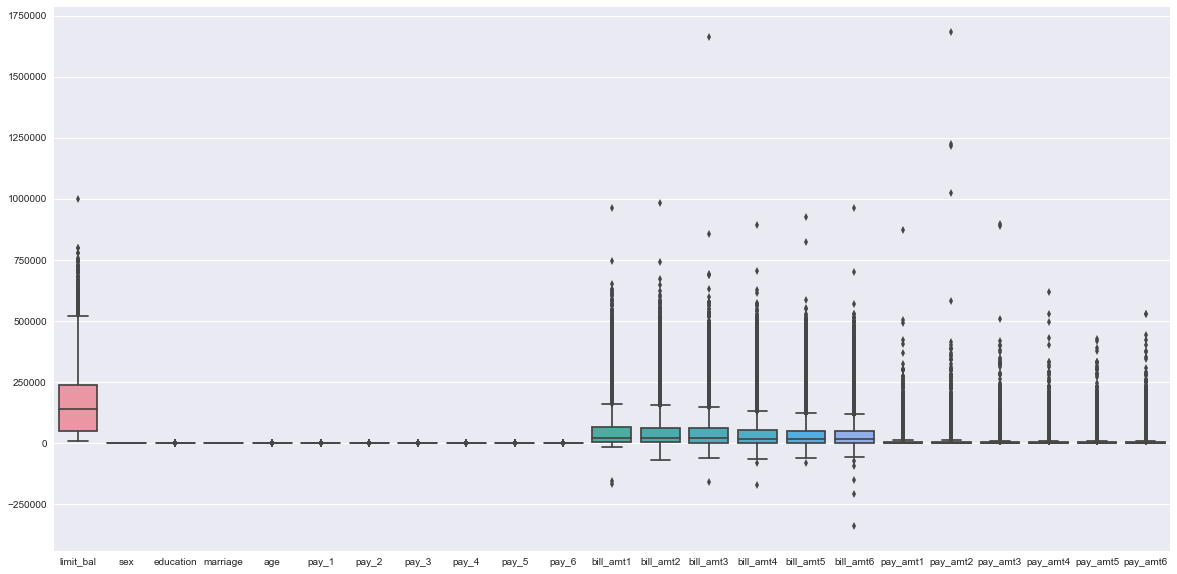

In [1253]:
## Validamos escala de valores entre las caractetisticas de modelado
f, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(data=X, ax=ax)

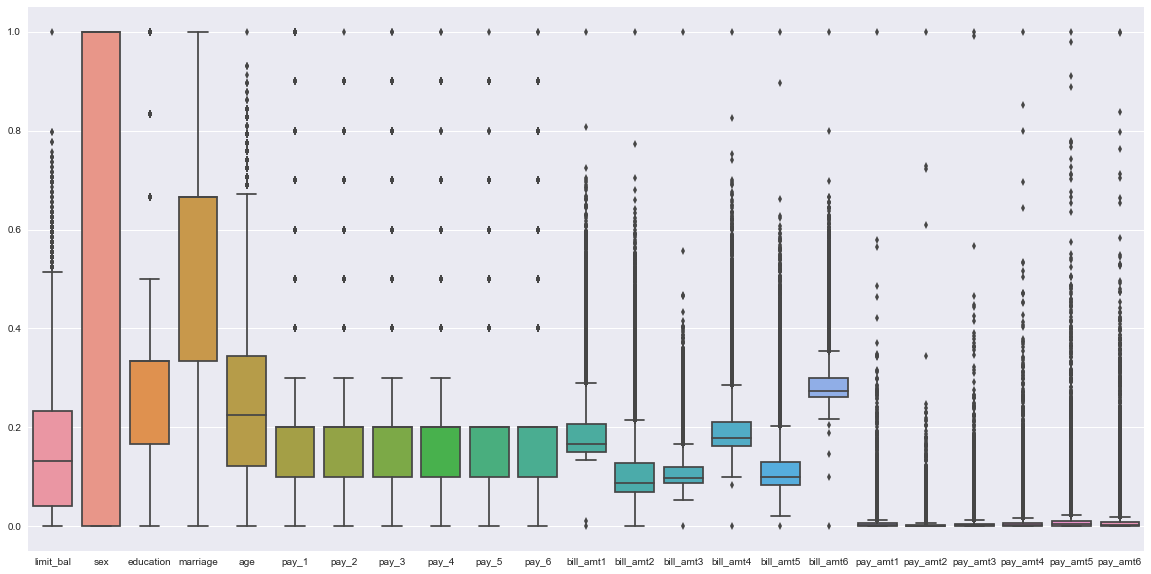

In [1254]:
##
## Normalizamos los datos de la matriz
##
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=X_names)

f, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(data=X, ax=ax)


# Selección de caracteristicas

Dado que la información disponible puede ser o no representativa para el modelo, se deben aplicar tecnicas de selección de caracteristicas para determinar cual información explica mejor la variable objetivo. En este caso aplicaremos los metodos:

- Feature Selection
- Principal Components Analysis (PCA)

Este analisis es importante por que en muchos casos, el conjunto de datos  contiene información que genera ruido en el modelo afectando sus metricas de evaluación.

Con ambos metodos compararemos un modelo con el conjunto inicial de variables versus el mismo con las variables selecionadas por el metodo de selección de variables, por lo cual tendremos los siguientes supuestos:

- Se conserva en ambos casos el porcentaje de Entrenamiento y prueba, del 80% y 20% resepectivamente.
- La misma semilla en las comparaciones para que no se afecte por las selecciones aleatorias.
- Se aplicará el mismo metodo de clasificaciones para que no influya en las comparaciones.

In [1255]:

#Preparación de conjuntos 

#Partición
X_train, X_test, y_train_true, y_test_true = train_test_split(
    X, y,                       # datos originales
    test_size=0.2,        # float/int, tamaño de la muestra de prueba
    random_state=44)  # semilla del generador aleatorio

#Modelo base
print(__doc__)
flc = RandomForestClassifier(n_jobs = 3)
flc.fit(X_train, y_train_true)
print(flc)
y_test_pred = flc.predict(X_test)

Automatically created module for IPython interactive environment
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=3, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


In [1256]:
#encontramos variables importantes por FS
vbles_imp_FS = flc.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(vbles_imp_FS)[::-1]

## Extraemos las n caracteristicas que cubran el 90% de importancia acumulada
df = pd.DataFrame(index=indices, data=vbles_imp_FS[indices], columns=["vbles_imp_FS"])
df.sort_values("vbles_imp_FS", ascending=False)
cumulative = 0
indices_new = []
for index, row in df.iterrows():
    if cumulative < 0.90:
        indices_new.append(index)
    else:
        break
    cumulative = cumulative + row['vbles_imp_FS']
indices_new = sorted(indices_new)

## Modelo de colomnas importantes
X_train_new = X_train[X_train.columns[indices_new]]
X_test_new = X_test[X_test.columns[indices_new]]

flc_new = RandomForestClassifier(n_jobs = 3)
print(clf)
flc_new.fit(X_train_new, y_train_true)
y_test_pred_new = flc_new.predict(X_test_new)

#Metrias de evaluación
accuracy = accuracy_score(y_true = y_test_true, y_pred = y_test_pred)
accuracy_fs = accuracy_score(y_true = y_test_true, y_pred = y_test_pred_new)
accuracy_dif = accuracy - accuracy_new
print()
print("acurracy original: {}% ".format(round(accuracy,4)))
print("acurracy Feature Selection: {}% ".format(round(accuracy_fs,4)))
print("Diferencia: {}% ".format(round(accuracy_dif,4)))


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=3, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

acurracy original: 0.8093% 
acurracy Feature Selection: 0.8135% 
Diferencia: 0.0022% 


Podemos observar que al aplicar la metodo FS, aúnque la metrica accuracy mejora, teoricamente no se considera representativa dado que no supera el indicador en 2.5%, por lo que se sigue considerando los grupos de entrenamiento iniciales sin selección.

In [1257]:
mejork = 0
mejor_accuracy = 0
rows, cols = X.shape
list_result = []
## Iteramos sobre varios k tratando de encontrar el mejor ajuste
print("k", "    accuracy", "     accuracy_pca", "     accuracy_dif")
for k in range(cols-20,cols,1):
    X_new = SelectKBest(chi2, k=k).fit_transform(X, y)
    X_train_new, X_test_new, y_train_true, y_test_true = train_test_split(X_new, y, 
                                                                          test_size=0.2, 
                                                                          random_state=44)  

    fcl_new = RandomForestClassifier(n_jobs = 3)
    fcl_new.fit(X_train_new, y_train_true)
    y_test_pred_new = fcl_new.predict(X_test_new)

    accuracy = accuracy_score(y_true = y_test_true, y_pred = y_test_pred)
    accuracy_pca = accuracy_score(y_true = y_test_true, y_pred = y_test_pred_new)
    accuracy_dif = accuracy - accuracy_new
  
    #list_result.append([accuracy, accuracy_new, accuracy_dif, k])

    print(k, "     ", round(accuracy,3), "         ", round(accuracy_pca,3), "          ", round(accuracy_dif,3))
    
    if accuracy_dif <= -0.025:   # La diferencia debe ser más de 2.5% de la precisión original
        #print("El ajuste por combinación de componentes es viable.")
        if mejor_accuracy < abs(accuracy_dif):
            X_train = X_train_new
            X_test = X_test_new
            mejork = k

#Print(list_result[2:6])
print()            
print("El mejor valor de k encontrado es:", mejor_accuracy)

print("acurracy original: {}% ".format(round(accuracy,4)))
print("acurracy Feature Selection: {}% ".format(round(accuracy_pca,4)))
print("Diferencia: {}% ".format(round(accuracy_dif,4)))

#data_result = pd.DataFrame(data=list_result,
#                           columns=['accuracy-org', 'accuracy-pca', 'difference', 'k-value'])
#data_result

k     accuracy      accuracy_pca      accuracy_dif
3       0.809           0.824            0.002
4       0.809           0.822            0.002
5       0.809           0.82            0.002
6       0.809           0.819            0.002
7       0.809           0.804            0.002
8       0.809           0.802            0.002
9       0.809           0.79            0.002
10       0.809           0.802            0.002
11       0.809           0.804            0.002
12       0.809           0.802            0.002
13       0.809           0.804            0.002
14       0.809           0.808            0.002
15       0.809           0.808            0.002
16       0.809           0.809            0.002
17       0.809           0.812            0.002
18       0.809           0.815            0.002
19       0.809           0.81            0.002
20       0.809           0.808            0.002
21       0.809           0.809            0.002
22       0.809           0.813            0.002

Con el metodo de Analisis de componentes principales, observamos que tampoco mejora el accuracy representativamente. 

Dado que los dos metodos evaluados no mejoran representativamente los resultados se procede a la elaboración de los modelos tomando el conjunto de datos sin seleción.

# Modelado

Para la elaboración del modelo predictivo, se usarán las siguientes tecnicas de clasificación:

- Vecinos más Cercanos (KNN)
- Arbol de decisión
- Maquinas de vectores de soporte (SVM)
- Random Forest

A los cuales se les aplicará cross-validation e hyper-parameters tuning.

Metricas a Evaluar:

- Accuracy
- F1
- Eecall
- Roc auc
- Jaccard similarity
- Confusion matrix


In [1258]:
#Selección de grupos de entrenamiento y prueba
#Utilizaremos una proporción de datos 70% y 30%, respectivamente

X_train, X_test, y_train_true, y_test_true = train_test_split(
    X, y,                       # datos originales
    test_size=0.3,        # float/int, tamaño de la muestra de prueba
    random_state=44)  # semilla del generador aleatorio

## Construimos un Random Forest por default y modelamos el proceso
## Utilizaremos estas predicciones para identificar agrupaciones de características
##
print(__doc__)
clf = RandomForestClassifier(n_jobs = 3)
clf.fit(X_train, y_train_true)
print(clf)
y_test_pred = clf.predict(X_test)


Automatically created module for IPython interactive environment
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=3, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


In [1259]:
##
## Definimos una función para ejecutar las metodologías
##
def fun_pred(classifier,
                       tuned_params,
                       scores):
    #start = tm.time() % 60
    result = []
    for score in scores:
        print()
        print("Parámetros ajustados del score: %s" % score)
        print()

        # Entrenamiento usando cross-validation con 3 folds
        clf = GridSearchCV(classifier, tuned_params, cv=3, scoring='%s_macro' % score, n_jobs=3)
        clf.fit(X_train, y_train_true)
        
        print("Mejores parámetros encontrados:")
        print(clf.best_params_)
        print()
        
        # Predicción con datos de prueba para validar metricas
        y_true, y_pred = y_test_true, clf.predict(X_test)
        
        #print("Reporte de clasificación detallado:")
        #print()
        #print(classification_report(y_true, y_pred))
        #print()
        
        accuracy_result = accuracy_score(y_true, y_pred)
        recall_result = recall_score(y_true, y_pred)
        f1_result = f1_score(y_true, y_pred)
        roc_auc_result = roc_auc_score(y_true, y_pred)
        jaccard_result = jaccard_similarity_score(y_true, y_pred)
        conf_matrix_result = confusion_matrix(y_true, y_pred)
        
        result.append([score, 
                              round(accuracy_result, 4), 
                              round(1-accuracy_result, 4), 
                              round(recall_result, 4), 
                              round(f1_result, 4), 
                              round(roc_auc_result, 4), 
                              round(jaccard_result, 4),
                              clf.best_params_,
                              conf_matrix_result])
    
    return(result)
    

Modelamos con KNN utilizando ajuste de hiperparametros con los siguientes valores de vecinos: 21, 31, 41.

In [1260]:
print(__doc__)

# Ajuste de parámetros para la metodología
tuned_params = [{'n_neighbors': [21, 31, 41]}]

# Metricas seleccionadas para validar metodología
scores = ['precision']

# Ejecutamos grid search para la metodología
knn_result = fun_pred(KNeighborsClassifier(), tuned_params, scores)

Automatically created module for IPython interactive environment

Parámetros ajustados del score: precision

Mejores parámetros encontrados:
{'n_neighbors': 41}



In [1261]:
print(__doc__)

# Ajuste de parámetros para la metodología
tuned_params = [{'max_depth': [5, 10, 20]}]

# Metricas seleccionadas para validar metodología
scores = ['precision']

# Ejecutamos grid search para la metodología
tree_result = fun_pred(DecisionTreeClassifier(), tuned_params, scores)

Automatically created module for IPython interactive environment

Parámetros ajustados del score: precision

Mejores parámetros encontrados:
{'max_depth': 5}



In [1262]:

print(__doc__)

# Ajuste de parámetros para la metodología
#tuned_params = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100]},
#                {'kernel': ['linear'], 'C': [1, 10, 100]}]
tuned_params = [{'kernel': ['rbf'], 'C': [1, 3, 5]}]

# Metricas seleccionadas para validar metodología
scores = ['precision']

# Ejecutamos grid search para la metodología
svm_result = fun_pred(SVC(), tuned_params, scores)

Automatically created module for IPython interactive environment

Parámetros ajustados del score: precision

Mejores parámetros encontrados:
{'C': 5, 'kernel': 'rbf'}



In [1263]:
print(__doc__)

# Ajuste de parámetros para la metodología
tuned_params = [{'n_estimators': [20, 50, 80]}]

# Metricas seleccionadas para validar metodología
scores = ['precision']

# Ejecutamos grid search para la metodología
forest_result = fun_pred(RandomForestClassifier(), tuned_params, scores)

Automatically created module for IPython interactive environment

Parámetros ajustados del score: precision

Mejores parámetros encontrados:
{'n_estimators': 80}



# Evaluación del los modelos

In [1264]:
## definimos Función que colorear el fondo del Data Frame
## 
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: cyan' if v else '' for v in is_max]

In [1265]:
##
## Construimos un Data Frame con todos los resultados de la evaluación
##
data_indexes = ["KNearestNeighbors", "DecisionTree", "RandomForest", "SupportVectorMachine"]
data_columns = ["score", "accuracy", "error_rate", "recall", "f1_score", "roc_auc",
                "jaccard_similarity", "best_params", "confusion_matriz"]
data_values = [list(chain.from_iterable(knn_result)),
               list(chain.from_iterable(tree_result)),
               list(chain.from_iterable(svm_result)),
               list(chain.from_iterable(forest_result))]
data_result = pd.DataFrame(data = data_values, columns = data_columns, index = data_indexes)

##
## Función para colorear fondo en un Data Frame
## http://pandas.pydata.org/pandas-docs/stable/style.html
##
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: coral' if v else '' for v in is_max]

##
## Mostramos los resultados de la evaluación con todos los scores
## Con un fondo de color se muestra la mejor estimación
##
data_result.iloc[:,:-1].style.apply(highlight_max, 
                                    subset=['accuracy', 'recall', 'f1_score', 'roc_auc', 'jaccard_similarity'])

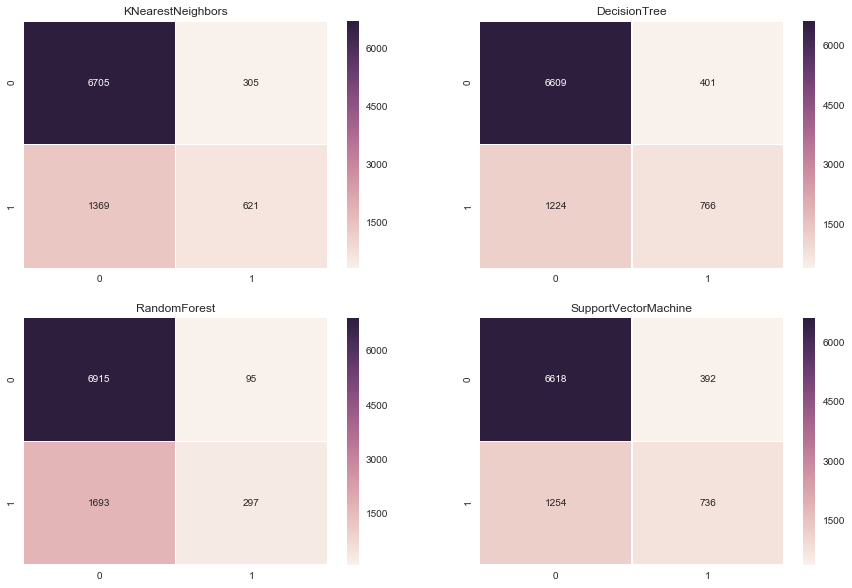

In [1266]:
##
## Graficamos las matrices de confusión para todos los estimadores
##
pred, true = ('predicted', 'true')
conf_matrix = list(chain.from_iterable(data_result.iloc[:,8:9].values))
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes[0, 0].set_title(data_indexes[0]); axes[0, 1].set_title(data_indexes[1])
axes[1, 0].set_title(data_indexes[2]); axes[1, 1].set_title(data_indexes[3])
axes[0, 0].set_xlabel(pred); axes[0, 0].set_ylabel(true)
axes[0, 1].set_xlabel(pred); axes[0, 1].set_ylabel(true)
axes[1, 0].set_xlabel(pred); axes[1, 0].set_ylabel(true)
axes[1, 1].set_xlabel(pred); axes[1, 1].set_ylabel(true)
sns.heatmap(conf_matrix[0], annot=True, fmt="d", linewidths=.5, ax=axes[0, 0])
sns.heatmap(conf_matrix[1], annot=True, fmt="d", linewidths=.5, ax=axes[0, 1])
sns.heatmap(conf_matrix[2], annot=True, fmt="d", linewidths=.5, ax=axes[1, 0])
sns.heatmap(conf_matrix[3], annot=True, fmt="d", linewidths=.5, ax=axes[1, 1])

In [1267]:
X_true.head()

NameError: name 'X_true' is not defined

In [ ]:
X.head()
